In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
headers = {
    'authority': 'www.amazon.in',
    'accept-language': 'en-US,en;q=0.9',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
    'referer': 'https://www.amazon.in/s?k=phone&crid=RAWCN8NS3GDA&sprefix=pho%2Caps%2C248&ref=nb_sb_noss_2'
}

In [3]:
def scrap_reviews(url):
    response = requests.get(url,headers=headers)
    soup = BeautifulSoup(response.text,"html.parser")
    review_divs = soup.find_all('div', class_='a-section review aok-relative')

    reviews = []
    for review_div in review_divs:
        reviewer_name = review_div.find('span', class_='a-profile-name').text.strip()
        review_title = review_div.find('a', class_='review-title-content').text.strip()
        review_body = review_div.find('span', class_='review-text-content').text.strip()
        review_rating = review_div.find('i', class_='review-rating').span.text.strip()
        reviews.append({'name':reviewer_name,'title':review_title,'body':review_body,'rating':review_rating})

    return pd.DataFrame(reviews)

In [4]:
url_first_page = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_unknown?ie=UTF8&reviewerType=all_reviews&pageNumber=1&filterByStar=five_star"
data = scrap_reviews(url_first_page)

In [5]:
for i in range(2,133):
    url_five_star = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_unknown?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)+"&filterByStar=five_star"
    new_data = scrap_reviews(url_five_star)
    data = pd.concat([data,new_data],axis=0,ignore_index=True)

In [6]:
for i in range(1,133):
    url_one_star = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_getr_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)+"&filterByStar=one_star"
    new_data = scrap_reviews(url_one_star)
    data = pd.concat([data,new_data],axis=0,ignore_index=True)

In [7]:
for i in range(1,54):
    url_three_star = "https://www.amazon.in/Samsung-Galaxy-Cloud-128GB-Storage/product-reviews/B08VB57558/ref=cm_cr_getr_d_paging_btm_next_53?ie=UTF8&reviewerType=all_reviews&pageNumber="+str(i)+"&filterByStar=three_star"
    new_data = scrap_reviews(url_three_star)
    data = pd.concat([data,new_data],axis=0,ignore_index=True)

In [8]:
data = data.sample(frac=1).reset_index(drop=True)

In [9]:
data.to_csv('galaxy_s20FE.csv',encoding='utf-8',index=False)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import re
import unicodedata
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### EDA

In [12]:
rawdata = pd.read_csv('galaxy_s20FE.csv',encoding='utf-8')

In [13]:
rawdata.head()

,name,title,body,rating
0,Customer review,1.0 out of 5 stars\nAppario retail private lim...,Appario retail private limited is selling faul...,1.0 out of 5 stars
1,gaurav_347,5.0 out of 5 stars\nAmazing phone!,I was confused between the oneplus 9r and this...,5.0 out of 5 stars
2,Sujith kumar,1.0 out of 5 stars\nNot satisfied,I am a redmi note 5 pro user and recently boug...,1.0 out of 5 stars
3,Customer,1.0 out of 5 stars\nNOT GOOD product,The back cover peeled off after 1.5 years of u...,1.0 out of 5 stars
4,kishore senagana,1.0 out of 5 stars\nReceived used phone,Received used phone. Raise complaint but didn'...,1.0 out of 5 stars


In [14]:
rawdata.isna().sum()

name      0
title     0
body      0
rating    0
dtype: int64

In [15]:
rawdata.duplicated(['title','body']).sum()

1

In [16]:
rawdata.drop_duplicates(['title','body'],inplace=True)

1.0 out of 5 stars    100
3.0 out of 5 stars    100
5.0 out of 5 stars     99
Name: rating, dtype: int64


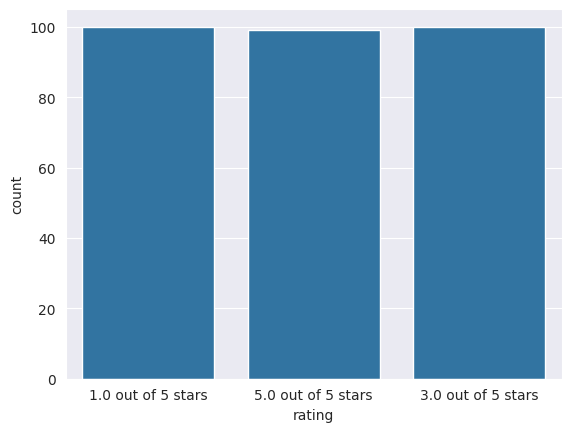

In [17]:
sns.countplot(x = rawdata['rating'])
print(rawdata['rating'].value_counts())


Combining title and body and only considering that as our final data

In [18]:
data = pd.DataFrame(rawdata['title']+' '+rawdata['body'].fillna(''), columns=['review'])

In [19]:
data.duplicated().sum()

0

In [20]:
data.isna().sum()

review    0
dtype: int64

<Axes: xlabel='review', ylabel='Count'>

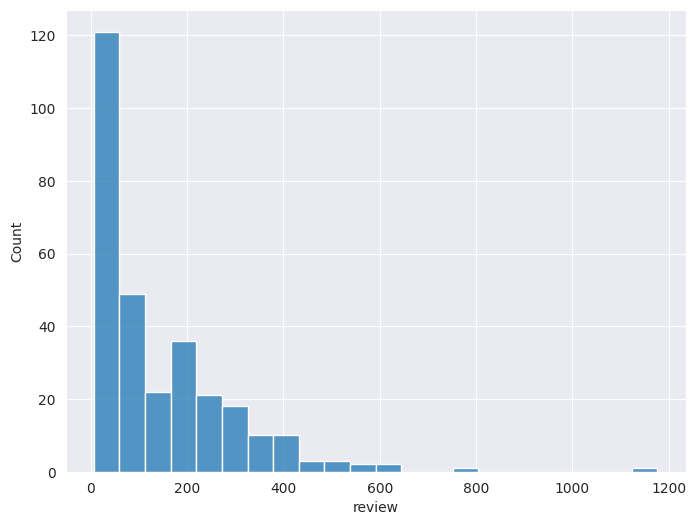

In [21]:
plt.figure(figsize=(8,6))
word_count = data['review'].apply(lambda x: len(str(x).split(" ")))
sns.histplot(word_count)

In [22]:
data['review'][2]

"1.0 out of 5 stars\nNot satisfied I am a redmi note 5 pro user and recently bought this. Many features in redmi such as dual apps, inbuilt app lock are not present in Samsung S20 FE 5G. Dual messenger is there in Samsung but it's limited to only specific apps.Battery is just 4000mah which is very bad for the cost of 26k and mi note 5 pro is just 13k even itoffers 5000mah battery lifeMoreover finger print is too bad and sometimes it never detects finger print, we have to give multiple tries to unlock.I would suggest mi users not to by Samsung if you are expecting above mentioned features"

In [23]:
data['review'].str.contains(r'http[s]?://[^\s]+',regex=True).value_counts()

False    299
Name: review, dtype: int64

In [24]:
data['review'].str.contains('\n').sum()

299

In [25]:
data['review'].str.contains(r'\[.*?\]').sum()

2

In [26]:
data['review'].str.contains(r'[^\w\s]|[\d]').sum()

299

In [27]:
data['cleaned'] = data['review'].str.replace(r"\n|[^\w\s]|[\d]|\[.*?\]",'',regex=True)

In [28]:
data['cleaned'] = data['cleaned'].str.lower()

In [29]:
def extract_named_entities(tweet):
    doc = nlp(tweet)
    entities = [entity.text for entity in doc.ents]
    return entities

name_list = data['cleaned'].apply(extract_named_entities)
name_list = [entity for sublist in name_list for entity in sublist]

<Axes: >

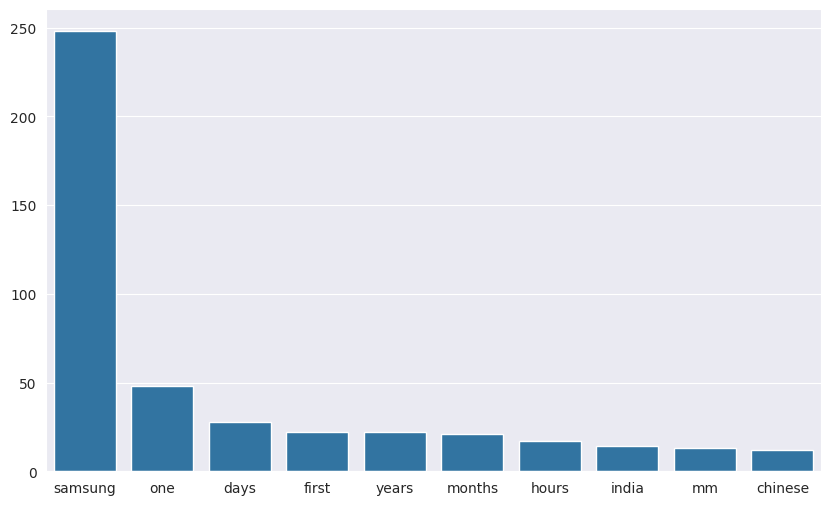

In [30]:
entity_counts = Counter(name_list)
top_10_names = [entity[0] for entity in entity_counts.most_common(10)]
top_10_counts = [entity[1] for entity in entity_counts.most_common(10)]
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_names,y=top_10_counts)

In [31]:
def remove_named_entities(text):
    for word in ['samsung','amazon','one','days','months','first','years','hai','phone']:
        return re.sub(word,'',text)

data['cleaned'] = data['cleaned'].apply(remove_named_entities)

In [34]:
stop = stopwords.words('english')

with open('stop.txt') as f:
    extra_stop = [word.strip('\n') for word in f.readlines()]

stop.extend(extra_stop)

# New Section

# New Section

In [35]:
# Define the phrase you want to remove
phrase_to_remove = "out of stars"

# Modify the lambda function to remove the specified phrase
data['without_stopwords'] = data['cleaned'].apply(lambda x: [word for word in x.lower().strip().split() if word != phrase_to_remove and word not in stop])


In [36]:
data.head()

,review,cleaned,without_stopwords
0,1.0 out of 5 stars\nAppario retail private lim...,out of starsappario retail private limited s...,"[starsappario, retail, private, limited, selli..."
1,5.0 out of 5 stars\nAmazing phone! I was confu...,out of starsamazing phone i was confused bet...,"[starsamazing, phone, confused, oneplus, phone..."
2,1.0 out of 5 stars\nNot satisfied I am a redmi...,out of starsnot satisfied i am a redmi note ...,"[starsnot, satisfied, redmi, note, pro, user, ..."
3,1.0 out of 5 stars\nNOT GOOD product The back ...,out of starsnot good product the back cover ...,"[starsnot, good, product, back, cover, peeled,..."
4,1.0 out of 5 stars\nReceived used phone Receiv...,out of starsreceived used phone received use...,"[starsreceived, phone, received, phone, raise,..."


In [37]:
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['without_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x]))

In [38]:
sia = SentimentIntensityAnalyzer()

data['score'] = data['lemmatized'].apply(lambda tweet: sia.polarity_scores(tweet)['compound'])
data['sentiment'] = data['score'].apply(lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral')

In [39]:
data.head()

,review,cleaned,without_stopwords,lemmatized,score,sentiment
0,1.0 out of 5 stars\nAppario retail private lim...,out of starsappario retail private limited s...,"[starsappario, retail, private, limited, selli...",starsappario retail private limited selling de...,-0.9652,Negative
1,5.0 out of 5 stars\nAmazing phone! I was confu...,out of starsamazing phone i was confused bet...,"[starsamazing, phone, confused, oneplus, phone...",starsamazing phone confused oneplus phone fina...,0.9918,Positive
2,1.0 out of 5 stars\nNot satisfied I am a redmi...,out of starsnot satisfied i am a redmi note ...,"[starsnot, satisfied, redmi, note, pro, user, ...",starsnot satisfied redmi note pro user recentl...,-0.7269,Negative
3,1.0 out of 5 stars\nNOT GOOD product The back ...,out of starsnot good product the back cover ...,"[starsnot, good, product, back, cover, peeled,...",starsnot good product back cover peeled year u...,0.4404,Positive
4,1.0 out of 5 stars\nReceived used phone Receiv...,out of starsreceived used phone received use...,"[starsreceived, phone, received, phone, raise,...",starsreceived phone received phone raise compl...,-0.6537,Negative


<Axes: xlabel='sentiment', ylabel='count'>

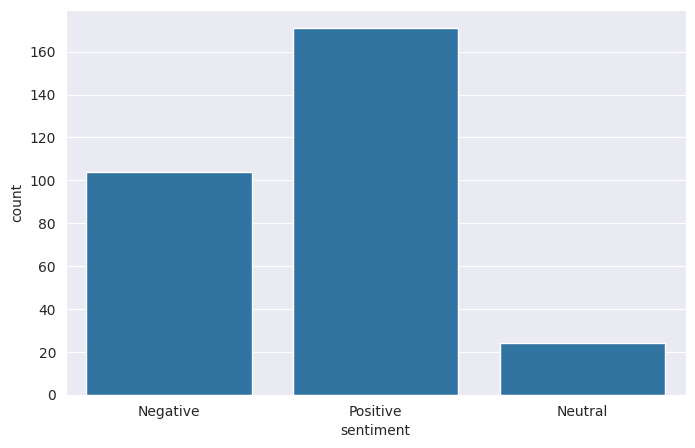

In [40]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='sentiment')

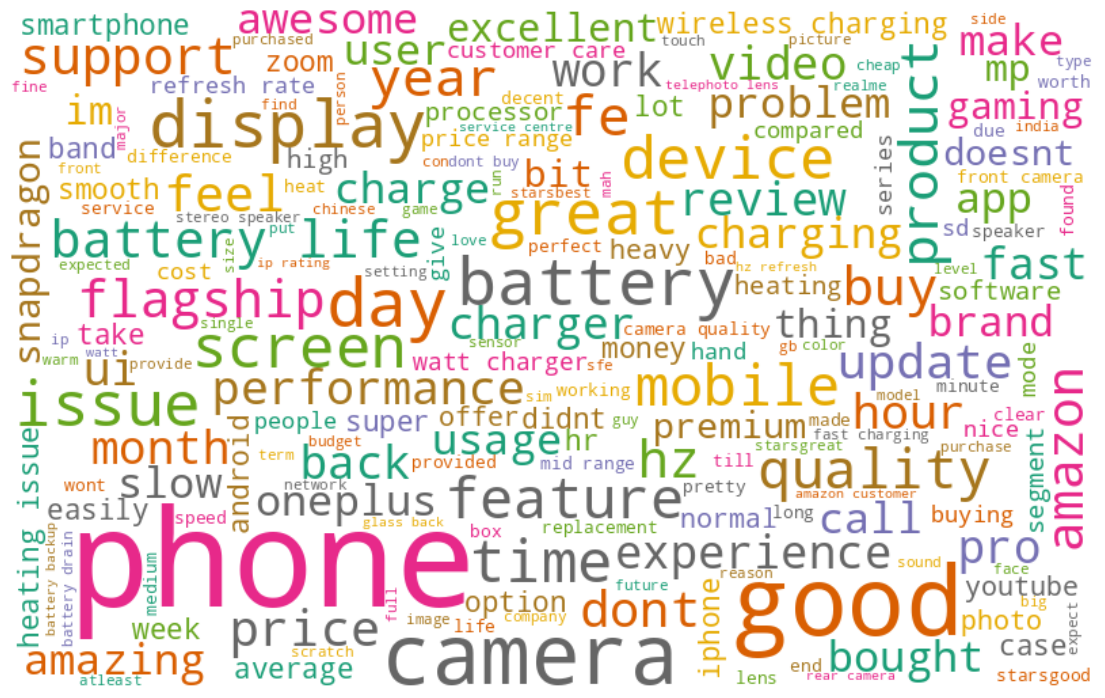

In [41]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2',background_color='white').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

all_words = ' '.join([text for text in data[data['sentiment']=='Positive']['lemmatized']])
generate_wordcloud(all_words)

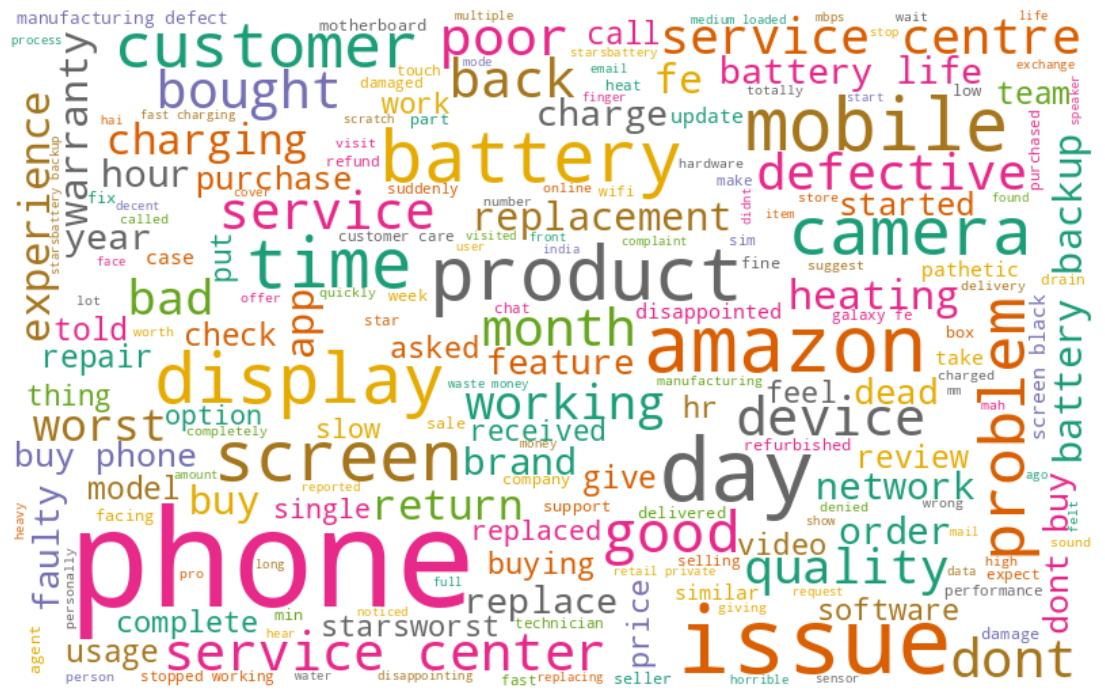

In [42]:
all_words = ' '.join([text for text in data[data['sentiment']=='Negative']['lemmatized']])
generate_wordcloud(all_words)

In [43]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf_features = vectorizer.fit_transform(data['lemmatized'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(),
                        columns=vectorizer.get_feature_names_out())

In [44]:
tfidf_df.head()

,absent,absolutely,acceptable,accepted,account,accuracy,accurate,acknowledge,action,actual,...,yeah,year,yesterday,yhis,youll,youre,youtube,yr,zenfone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.088445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.362107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
target_variable = data['sentiment'].apply(lambda x: 0 if x=='Negative' else 1)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df,target_variable,test_size=0.3,random_state=42)

In [47]:
classifier = MultinomialNB()
classifier.fit(x_train,y_train)

MultinomialNB()

In [48]:
y_pred = classifier.predict(x_test)

In [49]:
confusion_matrix(y_test,y_pred,labels=[True,False])

array([[53,  3],
       [27,  7]])

In [50]:
accuracy_score(y_test,y_pred)*100

66.66666666666666